## NIPS 2017 figure 3: application of likelihood-free to Hodgkin-Huxley

In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import likelihoodfree.io as io
import likelihoodfree.viz as viz
import likelihoodfree.PDF as lfpdf
import os

import svgutils.transform as sg

## Some parameters of the analysis

In [143]:
# to save or not to save plots
save_plot_flag = 1

###############################################################################
# divide or not to divide
div_fact = 0

###############################################################################
# number of repeats
seed_list = np.array([1,2,3])
num_rep = len(seed_list)

###############################################################################
# number of simulations per round
sim_step = 500
num_round = 5
num_sim = np.linspace(sim_step, num_round*sim_step, num_round).astype(int)

###############################################################################
# colors
col_original = (35/255,86/255,167/255)
col_SeNPE = (0, 174/255,239/255)
col_epfree = (105/255, 105/255, 105/255)
col_ibea = (244/255, 152/255, 25/255)

## Loading results for SeNPE, one seed

In [59]:
# loading filename and paths
prefix = 'hh_'+str(sim_step)+'_iwloss_svi_inc_data_seed'+str(seed_list[0])
basepath = '../results/hh/'
dir_nets = basepath + 'nets/'
dir_plots = basepath + 'plots/'
dir_ibea = basepath + 'ibea/'

# create folder for plots
if save_plot_flag:
    if not os.path.exists(dir_plots):
        os.makedirs(dir_plots)

###############################################################################
# loading data and posteriors
dists, infos, losses, nets, posteriors, sims = io.load_prefix(dir_nets, prefix)

# data
l_sims = list(sims.items())
obs_stats = l_sims[len(sims)-1][1].obs
y_obs = l_sims[len(sims)-1][1].obs_trace.reshape(-1,1)
labels_sum_stats = l_sims[len(sims)-1][1].labels_sum_stats

# posterior
l_posteriors = list(posteriors.items())
posterior = l_posteriors[len(l_posteriors)-1][1]

###############################################################################
# parameter labels
labels_params = l_sims[len(sims)-1][1].labels_params

###############################################################################
# ground-truth parameters
gt = l_sims[0][1].true_params
gt_log = np.log(l_sims[0][1].true_params)
n_params = l_sims[0][1].n_params

labels_params = l_sims[len(sims)-1][1].labels_params

init = l_sims[len(sims)-1][1].init

###############################################################################
# prior
prior_min = l_sims[len(sims)-1][1].prior_min
prior_max = l_sims[len(sims)-1][1].prior_max

###############################################################################
# time
t = l_sims[0][1].t
dt = l_sims[0][1].dt
duration = np.max(t)

###############################################################################
# input
I = l_sims[0][1].I_obs

###############################################################################
# if parameters in transformed space, inverse transform function
param_invtransform = l_sims[len(sims)-1][1].param_invtransform

###############################################################################
# simulator
bm = l_sims[len(sims)-1][1].bm

## Simulation of HH

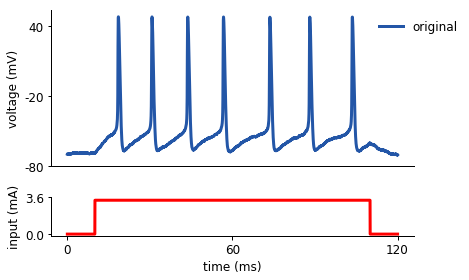

In [147]:
fig = plt.figure()

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(t, y_obs, color = col_original, lw=3, label='original')
plt.ylabel('voltage (mV)')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I,'r', lw=3)
plt.xlabel('time (ms)')
plt.ylabel('input (mA)')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, 1.1*np.max(I)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

plt.tight_layout()

if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_simul_NIPS2017_fig3.svg')
plt.show()

## Partial view of posterior

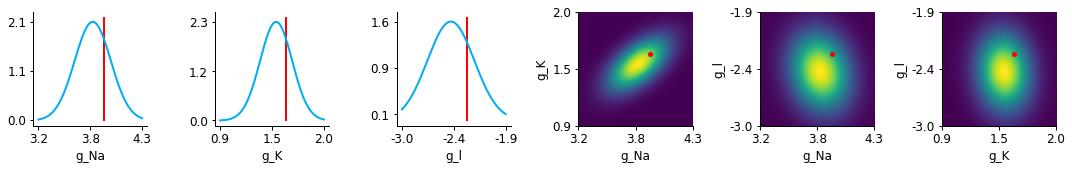

In [148]:
f = plt.subplots(1,6,figsize=(15,3))

levels=(0.68, 0.95)

for ii in range(min(posterior.ndim,3)):
    for j in range(ii,min(posterior.ndim,3)):

        if ii == j:
            ax = plt.subplot(1,6,ii+1)

            lims = np.array([prior_min[ii],prior_max[ii]])
            xx = np.linspace(lims[0], lims[1], 500)

            pp = posterior.eval(xx, ii=[ii], log=False)
            ax.plot(xx, pp, lw=2, color=col_SeNPE)
            ax.vlines(gt_log[ii], 0, ax.get_ylim()[1], lw=2, color='r')
            
            ax.set_xticks(np.linspace(min(lims),max(lims),3))
            ax.set_yticks(np.linspace(min(pp),max(pp),3))
            ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            
            plt.xlabel(labels_params[ii])
            
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect((x1-x0)/(y1-y0))

        else:
            ax = plt.subplot(1,6,3+ii+j)

            lims = np.array([[prior_min[ii],prior_max[ii]],[prior_min[j],
                              prior_max[j]]])
            xx = np.linspace(lims[0, 0], lims[0, 1], 500)
            yy = np.linspace(lims[1 ,0], lims[1, 1], 500)
            X, Y = np.meshgrid(xx, yy)
            xy = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

            pp = posterior.eval(xy, ii=[ii, j], log=False)
            pp = pp.reshape(list(X.shape))
            ax.imshow(pp,origin='lower',
                      extent=[lims[0, 0],lims[0, 1],lims[1 ,0],lims[1 ,1]],
                      aspect='auto', interpolation='none')
            ax.set_xlim(lims[0])
            ax.set_ylim(lims[1])
            ax.plot(gt_log[ii], gt_log[j], 'r.', ms=8)
            
            ax.set_xticks(np.linspace(min(lims[0]),max(lims[0]),3))
            ax.set_yticks(np.linspace(min(lims[1]),max(lims[1]),3))
            ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            
            plt.xlabel(labels_params[ii])
            plt.ylabel(labels_params[j])
            
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect((x1-x0)/(y1-y0))
            
plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_posterior_NIPS2017_fig3.svg')
plt.show()

## Loading results for epsilon-free and IBEA, one seed

In [149]:
# epsilon-free
prefix_ef = 'hh_'+str(sim_step)+'_svi_seed'+str(seed_list[0])
dists_ef, infos_ef, losses_ef, nets_ef, posteriors_ef, sims_ef = io.load_prefix(dir_nets, prefix_ef)

# data
l_sims_ef = list(sims_ef.items())

# posterior
l_posteriors_ef = list(posteriors_ef.items())
posterior_ef = l_posteriors_ef[len(l_posteriors_ef)-1][1]

###############################################################################
# ibea
offspring_size = int(sim_step)
max_ngen = int(num_round)
_, halloffame, log,_ = io.load(dir_ibea + 'ibea_offsp'
                               + str(offspring_size) +'_ngen' + str(max_ngen) + '.pkl')
best_params_ibea = halloffame[0]
best_sumstats_ibea = best_params_ibea.fitness.values
hlf_ibea = np.asarray(best_params_ibea)

## Modes and standard deviations

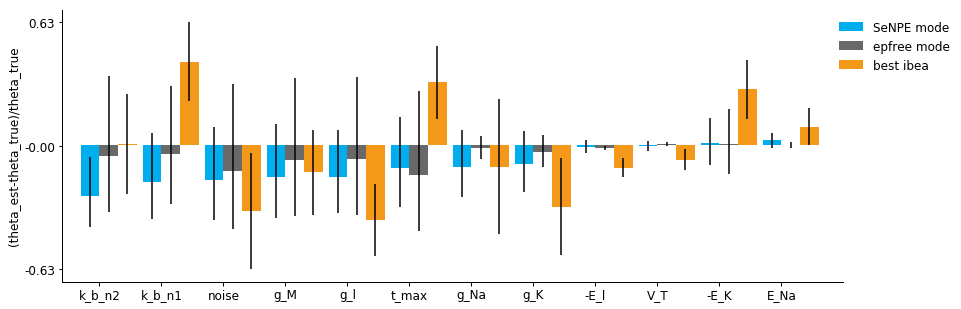

In [195]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot()

###############################################################################
# differences between true parameters and modes

# SeNPE
m, S = posterior.calc_mean_and_cov()
diff_params = np.divide(param_invtransform(m)-gt,gt)
err_params_up_norm = np.divide( (param_invtransform(m+np.sqrt(np.diag(S))) - param_invtransform(m)) , gt )
err_params_down_norm = np.divide( param_invtransform(m) - param_invtransform(m-np.sqrt(np.diag(S))) , gt )

# epsilon-free
m_ef, S_ef = posterior_ef.calc_mean_and_cov()
diff_params_ef = np.divide(param_invtransform(m_ef)-gt,gt)
err_params_up_norm_ef = np.divide( (param_invtransform(m_ef+np.sqrt(np.diag(S_ef))) - param_invtransform(m_ef)) , gt )
err_params_down_norm_ef = np.divide( param_invtransform(m_ef) - param_invtransform(m_ef-np.sqrt(np.diag(S_ef))) , gt )

# ibea
diff_params_ibea = np.divide(hlf_ibea-gt,gt)
err_params_ibea = np.divide( np.std(halloffame,0) , gt )

###############################################################################
# re-order
# sort_indices = np.argsort(diff_params-diff_params_ibea)
sort_indices = np.argsort(diff_params)
labels_params_sort = [labels_params[i] for i in sort_indices]

min_m = np.min([np.min(diff_params-err_params_down_norm),
                np.min(diff_params_ef-err_params_down_norm_ef),
                np.min(diff_params_ibea-err_params_ibea)])
max_m = np.max([np.max(diff_params+err_params_up_norm),
                np.max(diff_params_ef+err_params_up_norm_ef),
                np.max(diff_params_ibea+err_params_ibea)])

###############################################################################
# histogram of differences
width = 0.3
plt.bar(np.linspace(0,n_params-1,n_params),
        diff_params[sort_indices],width, color=col_SeNPE, align='center',
        yerr=[err_params_down_norm[sort_indices],
              err_params_up_norm[sort_indices]], ecolor='k', edgecolor = 'none', label='SeNPE mode')
plt.bar(np.linspace(0,n_params-1,n_params)+width,
        diff_params_ef[sort_indices],width,color=col_epfree, align='center',
        yerr=[err_params_down_norm_ef[sort_indices],
              err_params_up_norm_ef[sort_indices]], ecolor='k', edgecolor = 'none', label='epfree mode')
plt.bar(np.linspace(0,n_params-1,n_params)+2*width,
        diff_params_ibea[sort_indices],width,color=col_ibea, align='center',
        yerr=[err_params_ibea[sort_indices],err_params_ibea[sort_indices]],
        ecolor='k', edgecolor = 'none', label='best ibea')

plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
ax.set_xlim(-1.5*width,n_params+width/2)
ax.set_xticks(np.linspace(0,n_params-1,n_params)+width/2)
ax.set_yticks(np.linspace(min_m,max_m,3))
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
ax.set_xticklabels(labels_params_sort)
plt.ylabel('(theta_est-theta_true)/theta_true')


if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_compare_diffs_NIPS2017_fig3.svg')
plt.show()

## Samples from posterior

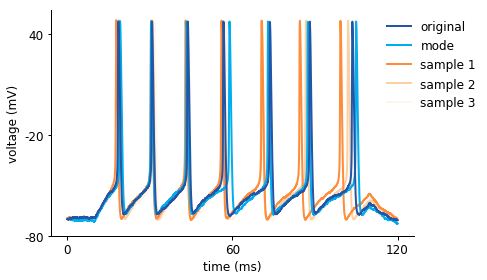

In [151]:
fig = plt.figure()
ax = plt.subplot()

num_samp = 3
num_colors = num_samp+1
cm1 = mpl.cm.Oranges
col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]

# sampling at contour of 1 covariance away from mean
x_samp = np.random.randn(n_params,num_samp)
x_samp = np.divide(x_samp,np.linalg.norm(x_samp,axis=0))
x_samp = (np.dot(S,x_samp)).T+m

params = np.concatenate((np.array([gt,param_invtransform(m)]),param_invtransform(x_samp)))

V = np.zeros((len(t),1+num_samp))
for i in range(1+num_samp):
    hh = bm.HH(init, params[i,:].reshape(1,-1),seed=230+i)
    V[:,i] = hh.sim_time(dt, t, I)[:,0]
    if i>0:
        plt.plot(t, V[:, i], color = col1[i-1], lw=2, label='sample '+str(num_samp-i+1))

# plotting simulation
plt.plot(t, V[:, 0], color=col_SeNPE, lw=2, label='mode')
plt.plot(t, y_obs, color=col_original, lw=2, label='original')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, 1), loc='upper right')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([-80, -20, 40])

plt.tight_layout()

if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_multi_simul_NIPS2017_fig3.svg')
plt.show()

## Application to real data

In [ ]:
# load results of SeNPE

# real data trace, SeNPE mode and sample traces

# posterior

## Plotting (i) HH simulation, (ii) partial view of posterior, (iii) samples from posterior, (iv) means and stds of parameters with our method, Murray and IBEA, (v) application to real data

In [197]:
#create new SVG figure
fig = sg.SVGFigure("16cm", "9cm")

# load matpotlib-generated figures
fig1 = sg.fromfile(dir_plots + 'fig_simul_NIPS2017_fig3.svg')
fig2 = sg.fromfile(dir_plots + 'fig_posterior_NIPS2017_fig3.svg')
fig3 = sg.fromfile(dir_plots + 'fig_multi_simul_NIPS2017_fig3.svg')
fig4 = sg.fromfile(dir_plots + 'fig_compare_diffs_NIPS2017_fig3.svg')
# fig5 = sg.fromfile(dir_plots + 'fig_realdata_posterior_NIPS2017_fig3.svg')


# get the plot objects
plot1 = fig1.getroot()
plot1.moveto(20, 15, scale=0.3)
plot2 = fig2.getroot()
plot2.moveto(165, 15, scale=0.36)
plot3 = fig3.getroot()
plot3.moveto(15, 110, scale=0.4)
plot4 = fig4.getroot()
plot4.moveto(220, 110, scale=0.34)
# plot5 = fig5.getroot()
# plot5.moveto(15, 130, scale=0.5)

# add text labels
txt1 = sg.TextElement(10,15, "A", size=12, weight="bold")
txt2 = sg.TextElement(160,15, "B", size=12, weight="bold")
txt3 = sg.TextElement(10,110, "C", size=12, weight="bold")
txt4 = sg.TextElement(210,110, "D", size=12, weight="bold")
txt5 = sg.TextElement(10,230, "E", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4])
fig.append([txt1, txt2, txt3, txt4, txt5])

# save figure
if save_plot_flag == 1:
    fig.save(dir_plots + 'NIPS2017_fig3.svg')

## Supplementary figure: full posterior for HH

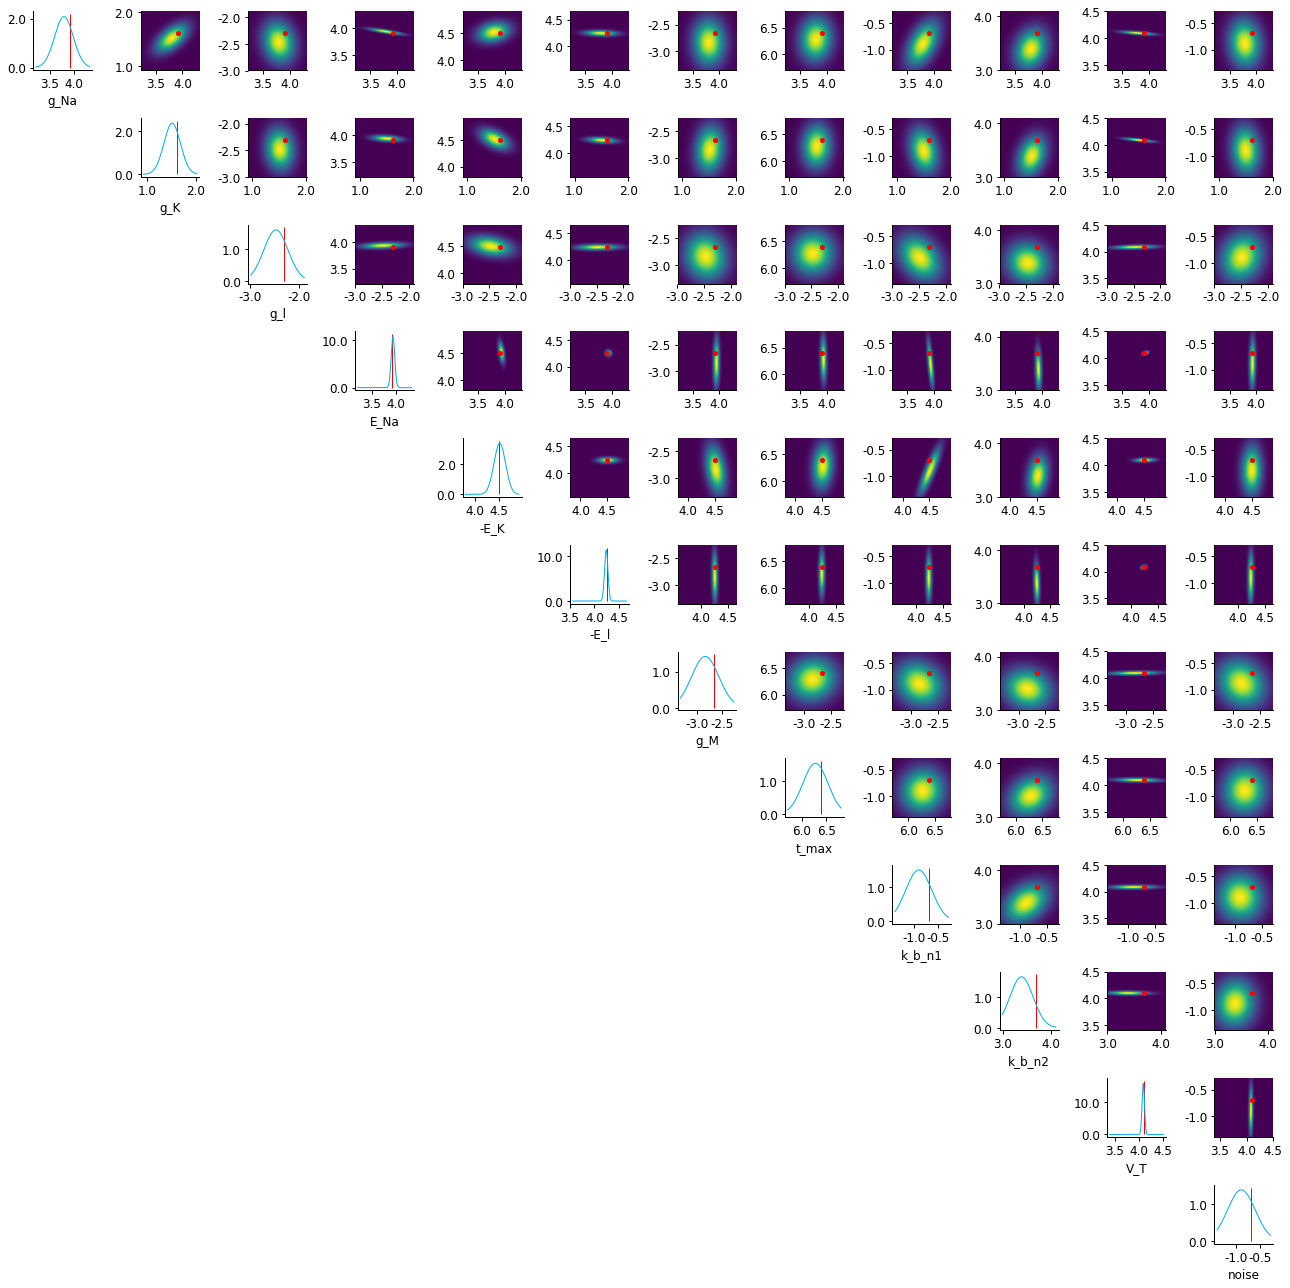

In [153]:
f, axs = plt.subplots(1,3,figsize=(np.maximum(5,1.5*posterior.ndim),
                               np.maximum(5,1.5*posterior.ndim)))

for ii in range(posterior.ndim):
    for j in range(ii,posterior.ndim):

        if ii == j:
            ax = plt.subplot2grid((posterior.ndim, posterior.ndim), (ii,j))

            lims = np.array([prior_min[ii],prior_max[ii]])
            xx = np.linspace(lims[0], lims[1], 500)

            pp = posterior.eval(xx, ii=[ii], log=False)
            ax.plot(xx, pp, lw=1, color=col_SeNPE)
            ax.vlines(gt_log[ii], 0, ax.get_ylim()[1], lw=1, color='r')
            
#             ax.set_xticks(np.linspace(min(lims),max(lims),3))
#             ax.set_yticks(np.linspace(min(pp),max(pp),3))
            ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            
            plt.xlabel(labels_params[ii])
            
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect((x1-x0)/(y1-y0))
            
        else:
            ax = plt.subplot2grid((posterior.ndim, posterior.ndim), (ii,j))

            lims = np.array([[prior_min[ii],prior_max[ii]],[prior_min[j],
                              prior_max[j]]])
            xx = np.linspace(lims[0, 0], lims[0, 1], 500)
            yy = np.linspace(lims[1 ,0], lims[1, 1], 500)
            X, Y = np.meshgrid(xx, yy)
            xy = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

            pp = posterior.eval(xy, ii=[ii, j], log=False)
            pp = pp.reshape(list(X.shape))
            ax.imshow(pp,origin='lower',
                      extent=[lims[0, 0],lims[0, 1],lims[1 ,0],lims[1 ,1]],
                      aspect='auto', interpolation='none')
            ax.set_xlim(lims[0])
            ax.set_ylim(lims[1])
            ax.plot(gt_log[ii], gt_log[j], 'r.', ms=8)
            
#             ax.set_xticks(np.linspace(min(lims[0]),max(lims[0]),3))
#             ax.set_yticks(np.linspace(min(lims[1]),max(lims[1]),3))
            ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
            
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect((x1-x0)/(y1-y0))
            
            
plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'NIPS2017_suppfig_HH.pdf')
plt.show()